In [1]:
import xarray as xr
import pandas as pd
from utilities.plotting import *
from utilities.utils import *

In [2]:
gas_costs = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
         120, 140, 160, 180, 200, 
         220, 240, 260, 280, 300,
         320, 340, 360, 380, 400,
         420, 440, 460, 480, 500]
countries = ['United States of America', 'Germany', 'China', 'Saudi Arabia']
colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0, 1, int(len(countries))*2)[2:])
case = 'CST_storage'
output_path = 'output_data/cst_storage'

In [3]:
vars_dict = {'capacity_natgas': None, 'capacity_cst': None, 'cs_fraction': None, 'storage_ratio': None, 'system_cost': None}

for var in vars_dict.keys():
    variable_df = pd.DataFrame()
    for gas_cost in gas_costs:
        masked_dataset = mask_data_region(xr.open_dataset(f'{output_path}/maps/{var}_{case}_gas{gas_cost}.nc'), get_world())
        variable_df = calculate_country_median(variable_df, masked_dataset, var, countries, gas_cost)
    vars_dict[var] = variable_df

plotting_variables_df = pd.concat(
    [vars_dict[k] if i == 0 else vars_dict[k].drop(columns=['country', 'gas cost']) 
     for i, k in enumerate(vars_dict)], 
    axis=1
)

In [4]:
# Save the DataFrame to a CSV file
if not os.path.exists(f'{output_path}/plotting_variables'):
    os.makedirs(f'{output_path}/plotting_variables')
plotting_variables_df.to_csv(f'{output_path}/plotting_variables/plotting_variables_df.csv', index=False)

/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/plotting.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotting_df_sub[f'median co2_emissions'] = 1 - plotting_df_sub['median cs_fraction']
/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/plotting.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotting_df_sub.loc[:, f'lower error {var}'] = -1 * plotting_df_sub[f'lower error cs_fraction']
/central/groups/carnegie_poc/awongel/clab_concentrated_solar/ut

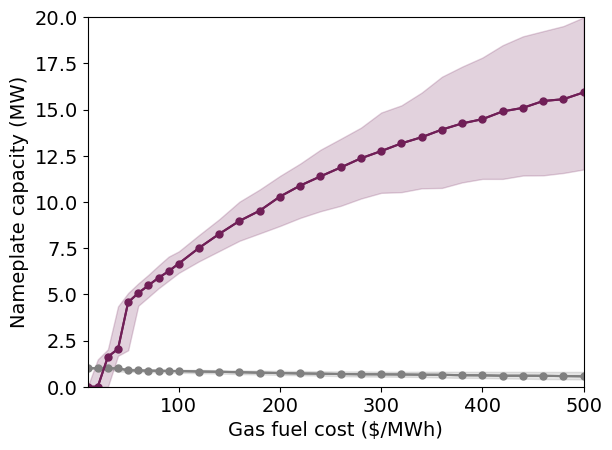

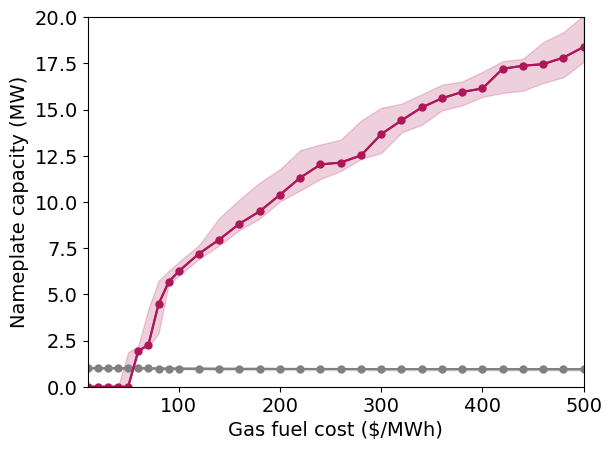

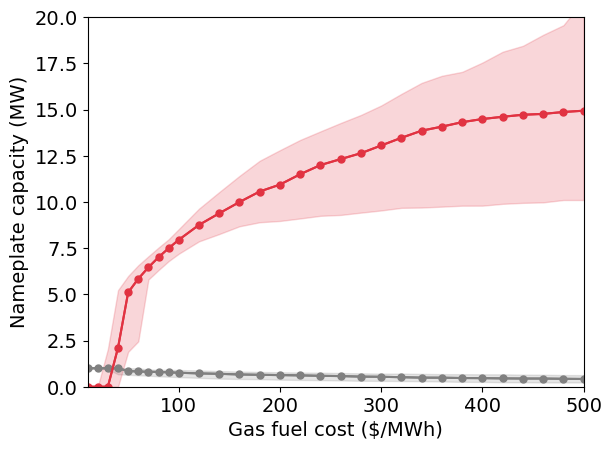

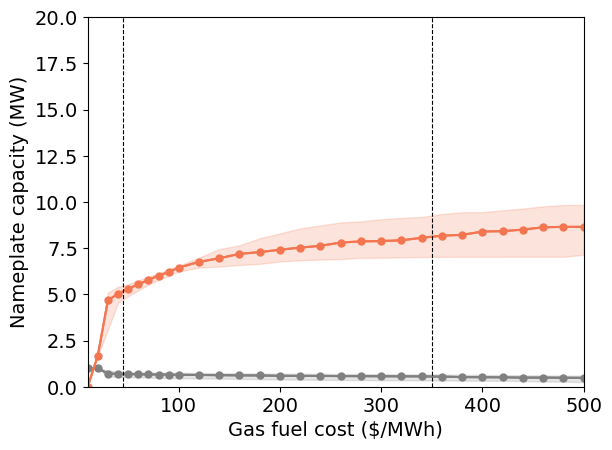

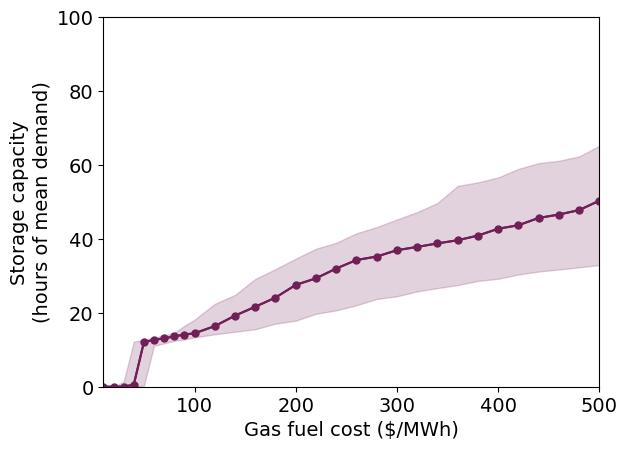

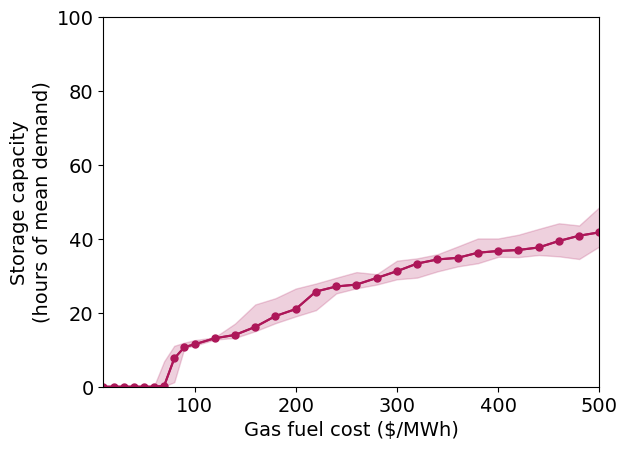

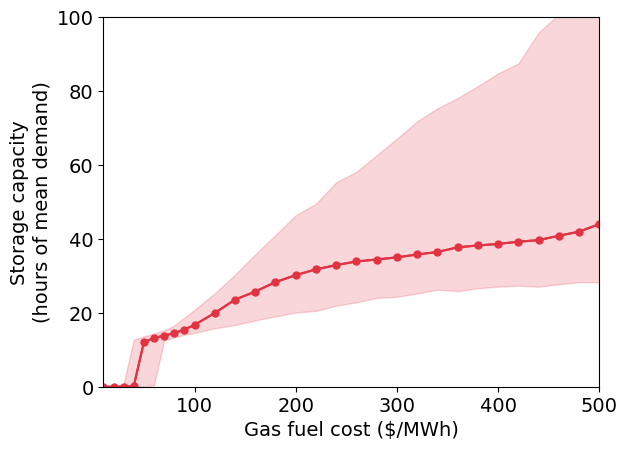

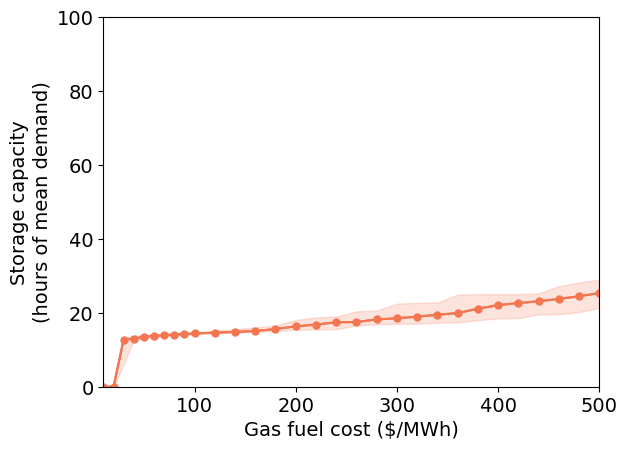

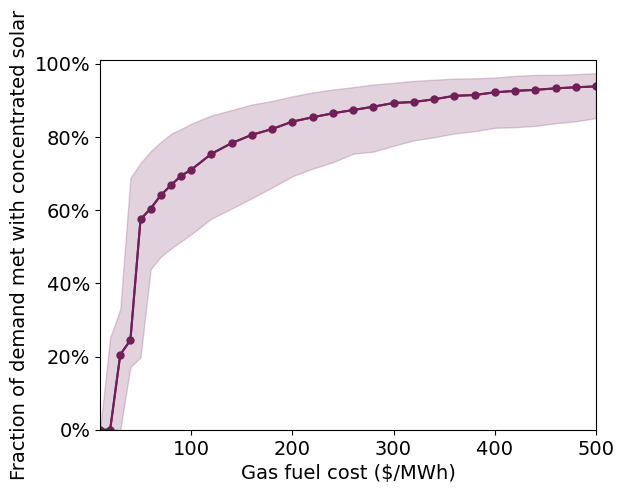

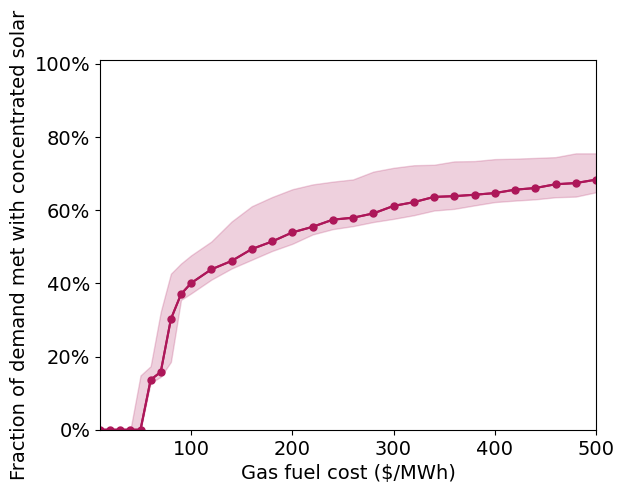

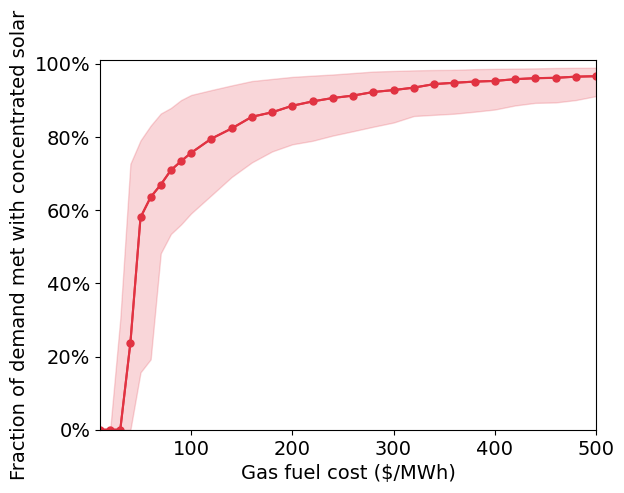

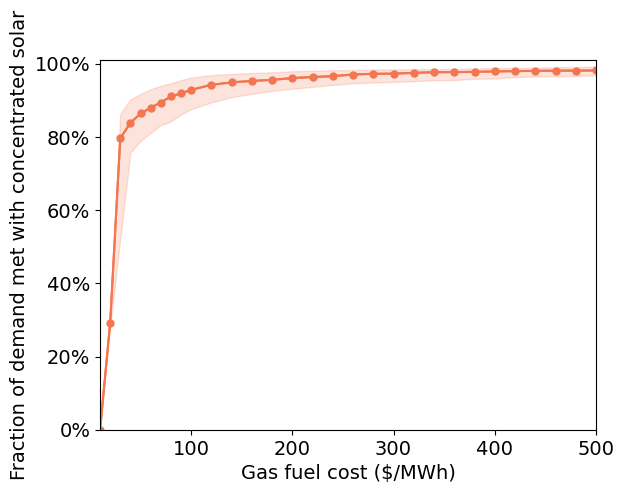

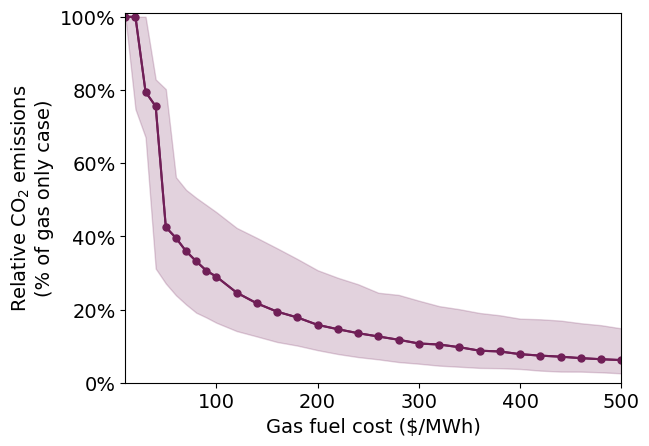

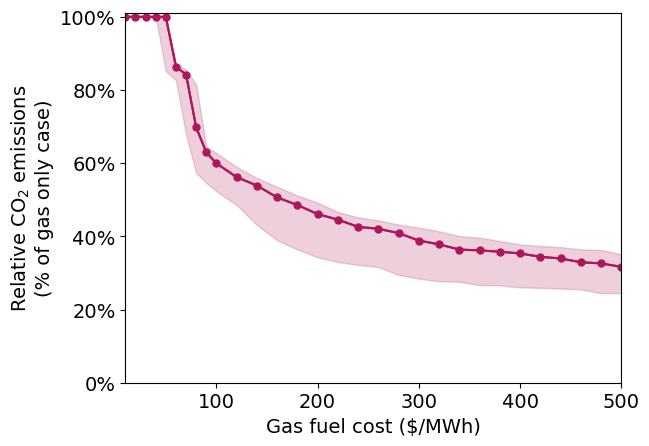

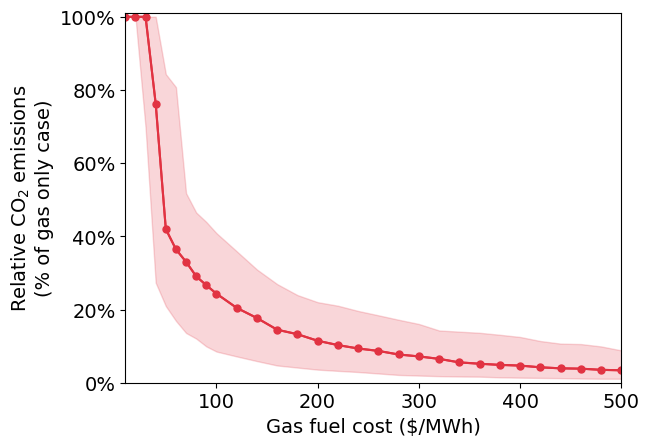

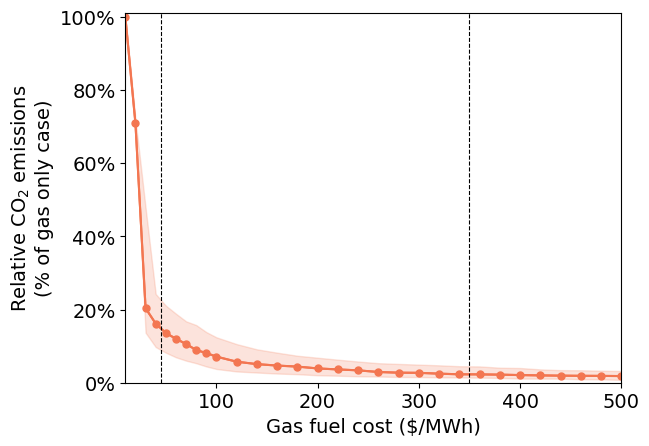

In [5]:
for var in ['capacities', 'storage_ratio', 'cs_fraction', 'co2_emissions']:
    for ic,country in enumerate(countries):
        plot_line(plotting_variables_df, country, colors[ic], var)

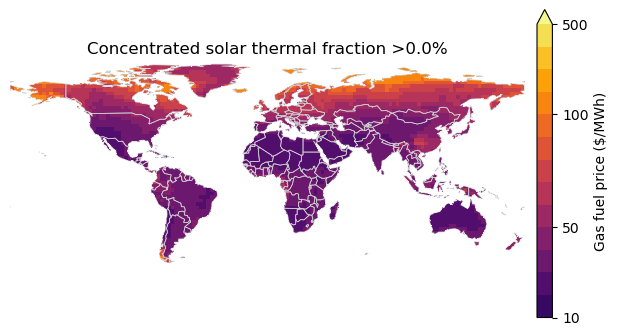

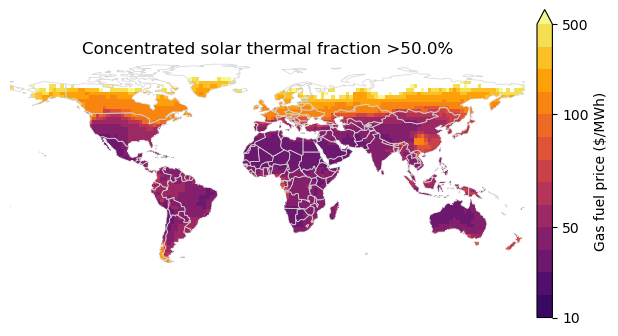

In [6]:
for frac_threshold in ['0p0', '0p5']:
    plot_result_map(f'{output_path}/maps/gas_price_min_frac_CST_storage_threshold{frac_threshold}.nc', 'CST_storage', f'Concentrated solar thermal fraction >{float(frac_threshold.replace("p","."))*100}%', 'Gas fuel price ($/MWh)')

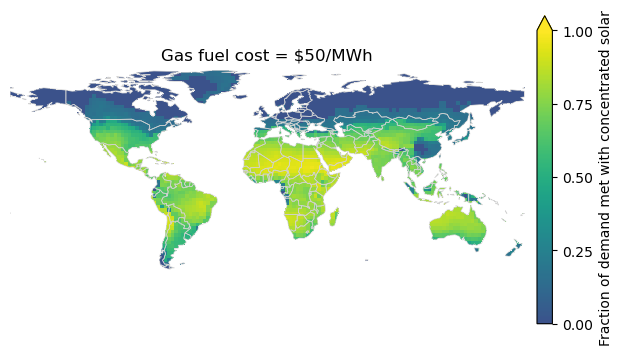

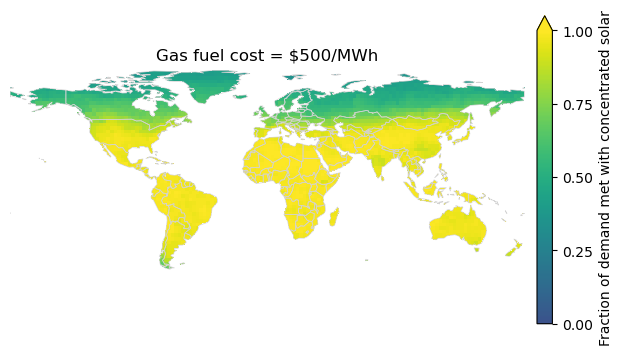

In [7]:
for gas_cost in [50, 500]:
    plot_result_map(f'{output_path}/maps/cs_fraction_CST_storage_gas{gas_cost}.nc', 'CST_storage', f'Gas fuel cost = ${gas_cost}/MWh', 'Fraction of demand met with concentrated solar')

/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transform

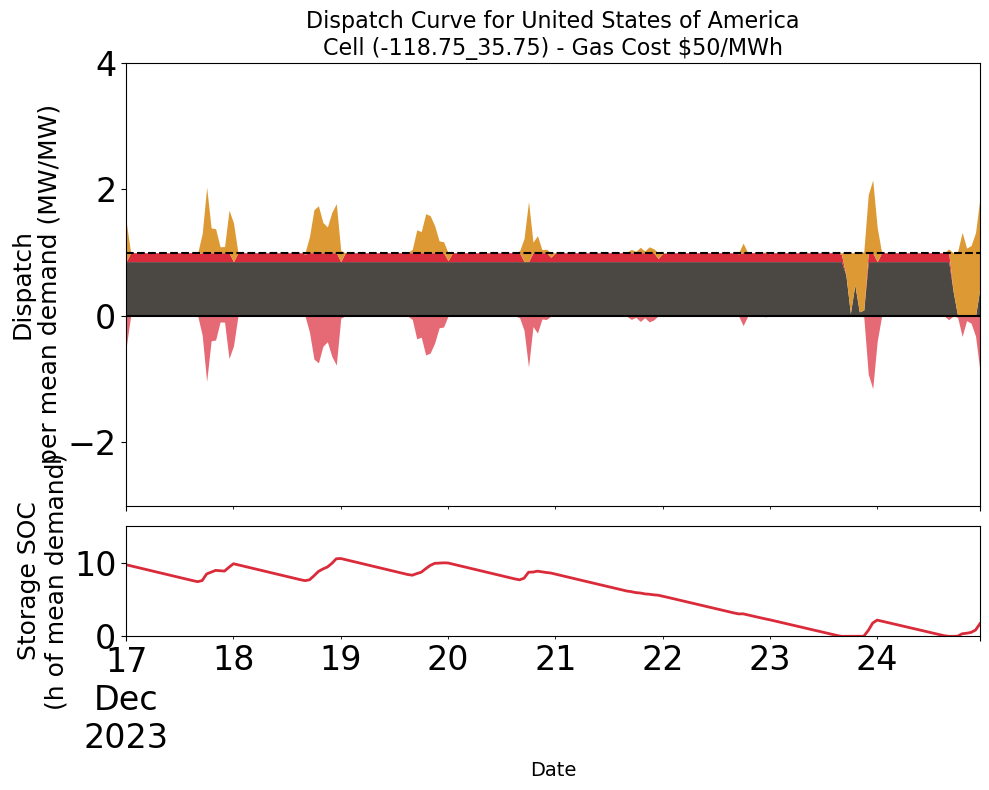

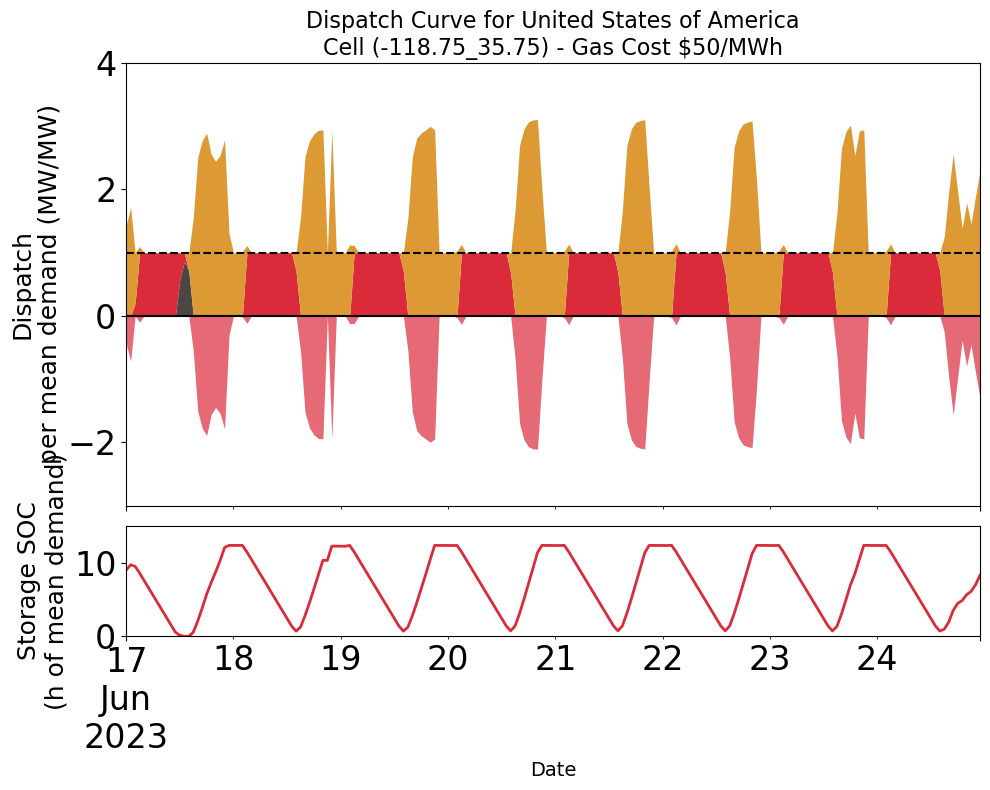

<Figure size 600x400 with 0 Axes>

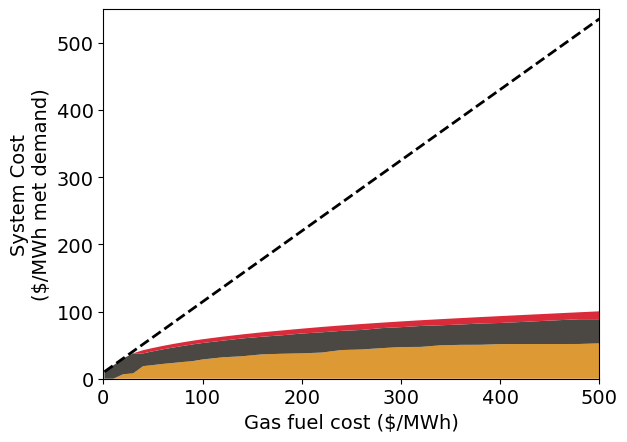

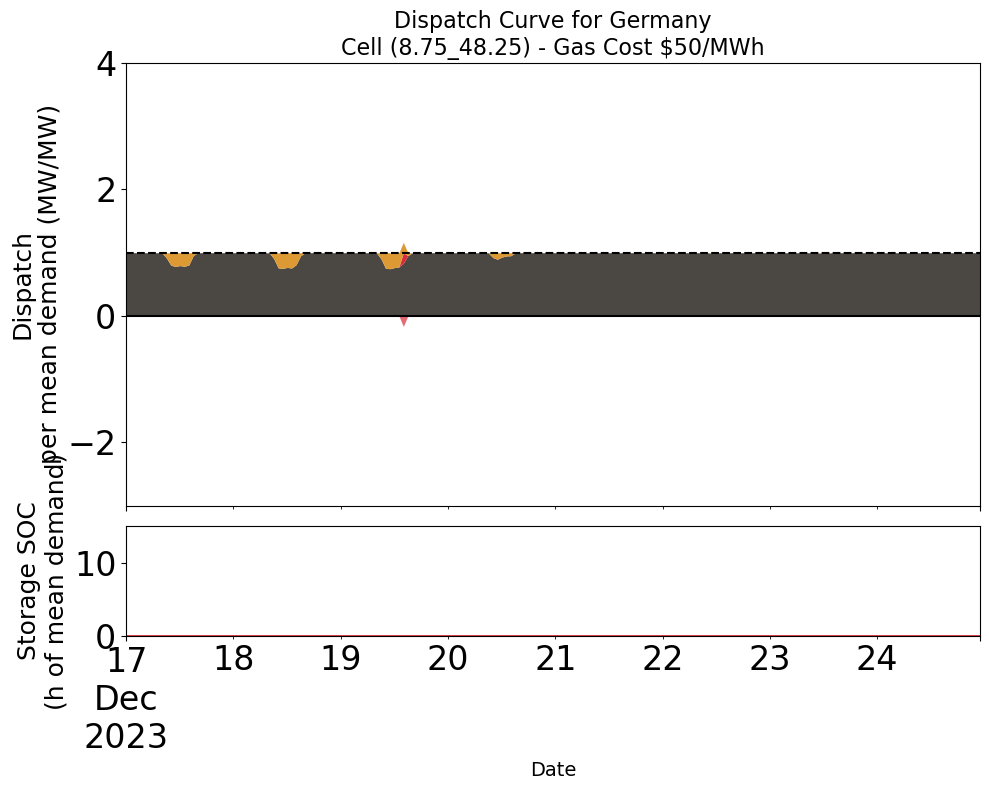

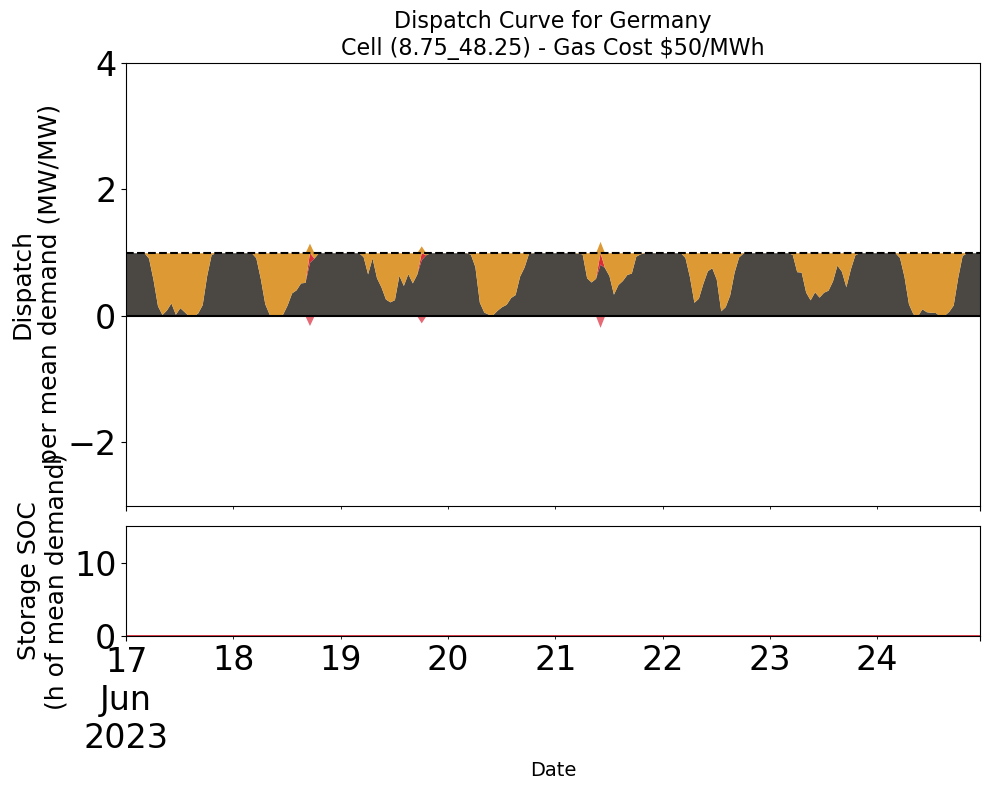

<Figure size 600x400 with 0 Axes>

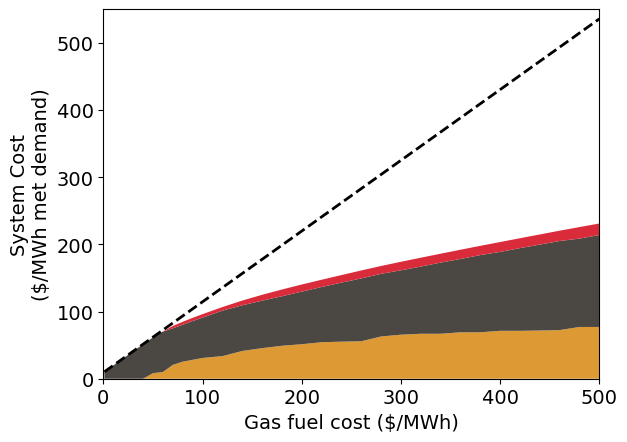

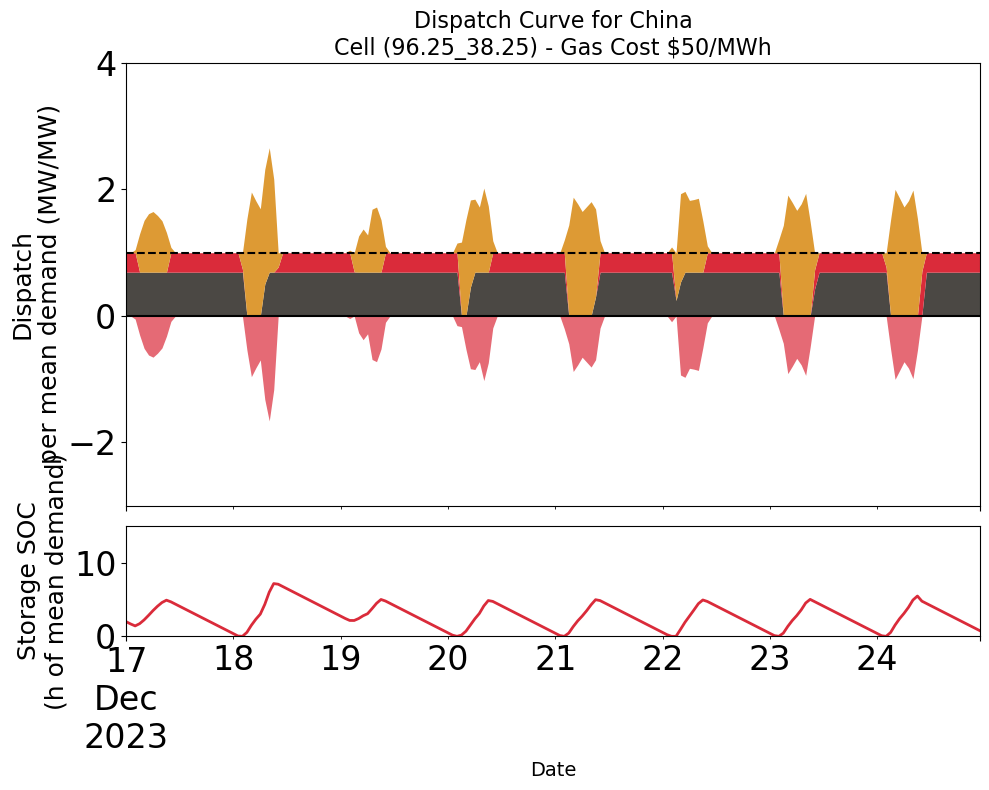

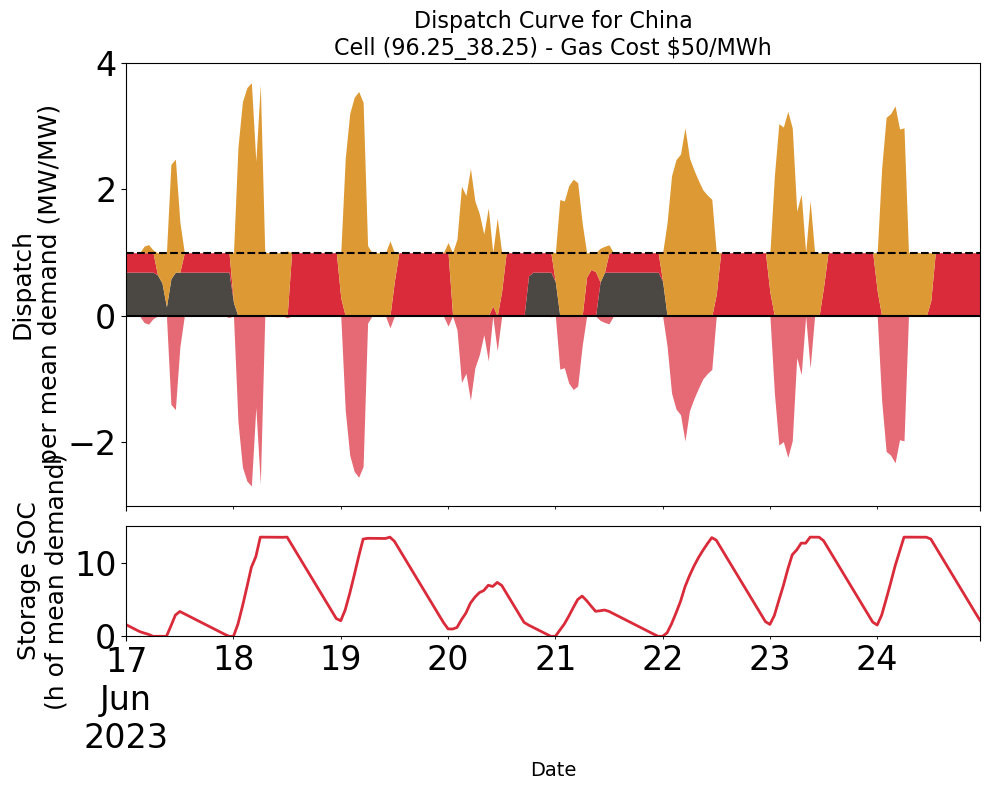

<Figure size 600x400 with 0 Axes>

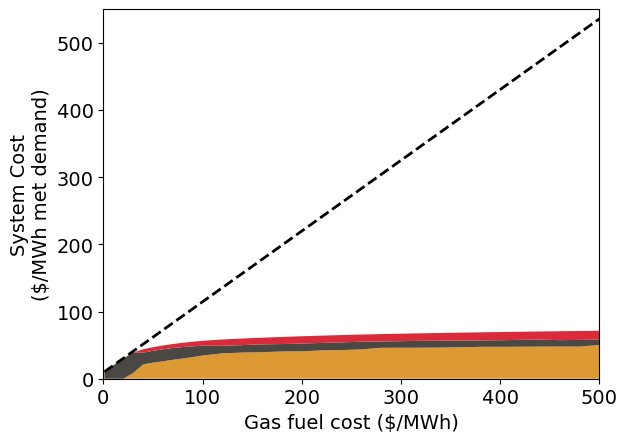

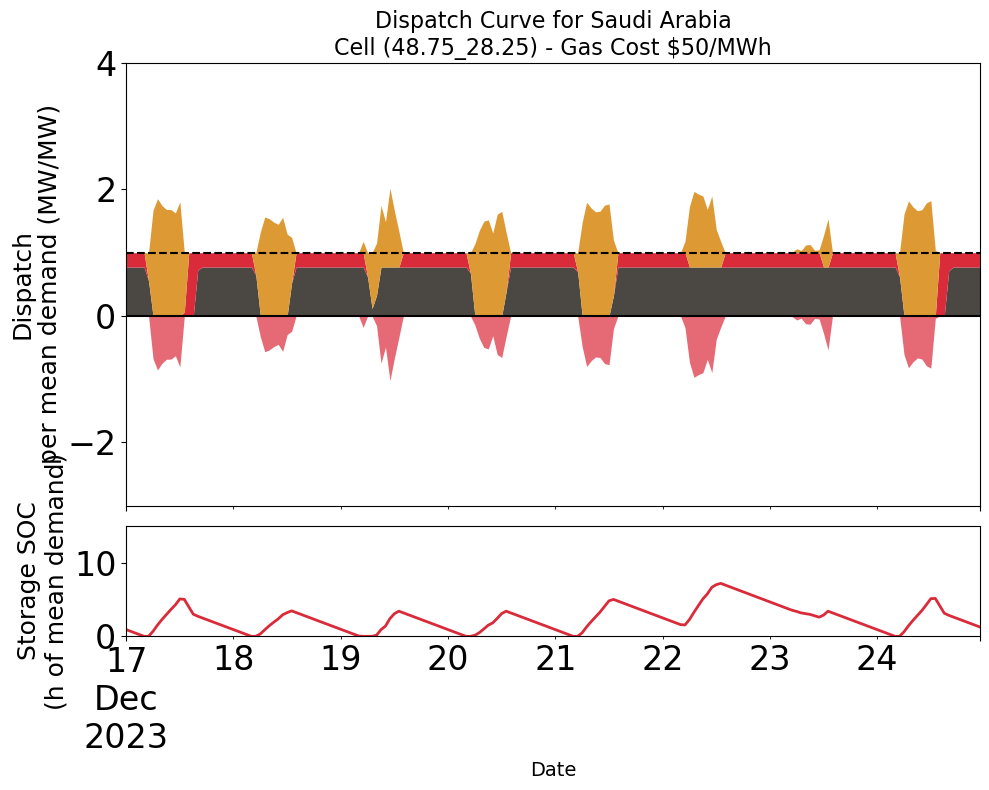

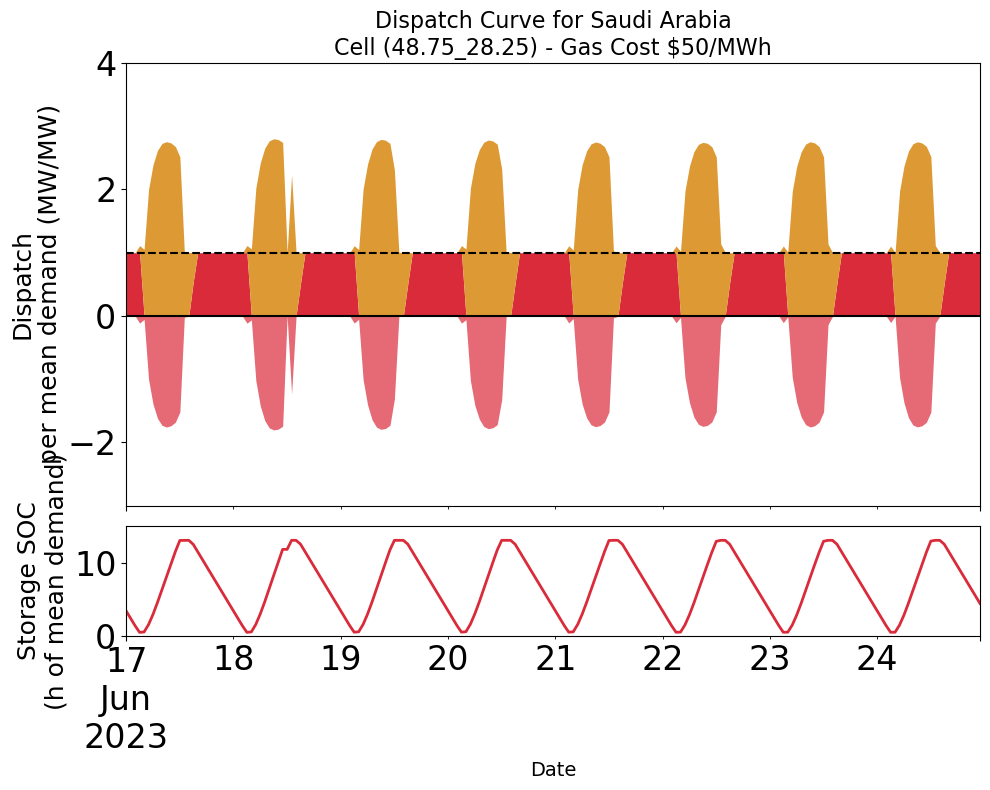

<Figure size 600x400 with 0 Axes>

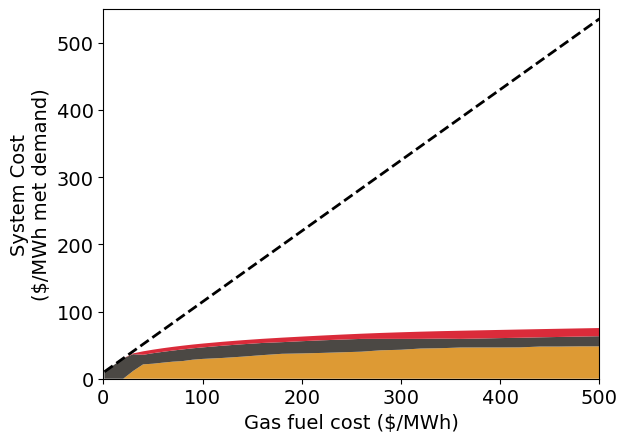

In [8]:
country_cell_dict = {
    'United States of America': ['-118.75°,35.75°', 50],
    'Germany': ['8.75°,48.25°', 50],
    'China': ['96.25°,38.25°', 50],
    'Saudi Arabia': ['48.75°,28.25°', 50]
}
for country in country_cell_dict.keys():
    plot_dispatch_curve(output_path, country, country_cell_dict[country][0].replace("°","").replace(",","_"), country_cell_dict[country][1], month='12')
    plot_dispatch_curve(output_path, country, country_cell_dict[country][0].replace("°","").replace(",","_"), country_cell_dict[country][1], month='06')

    gas_cost_dict, total_system_cost_dict = plot_system_cost_share(output_path, country, country_cell_dict[country][0].replace("°","").replace(",","_"), gas_costs)

In [9]:
for country in country_cell_dict.keys():
    calculate_co2_abatement_cost(country, plotting_variables_df, gas_cost_dict, total_system_cost_dict, gas_cost=50)

Country: United States of America, Gas cost: 50, CST fraction: 0.57, Emissions: 0.077 ton CO2/MWh, Abatement cost: $-179.45/ton CO2
Country: Germany, Gas cost: 50, CST fraction: 0.00, Emissions: 0.181 ton CO2/MWh, Abatement cost: $-inf/ton CO2
Country: China, Gas cost: 50, CST fraction: 0.58, Emissions: 0.076 ton CO2/MWh, Abatement cost: $-177.80/ton CO2
Country: Saudi Arabia, Gas cost: 50, CST fraction: 0.86, Emissions: 0.025 ton CO2/MWh, Abatement cost: $-119.37/ton CO2


/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/utils.py:256: RuntimeWarning: divide by zero encountered in scalar divide
  abatement_cost = (total_system_cost_dict[gas_cost] - gas_cost_dict[gas_cost]) / (0.181 - emissions)  # $/ton CO2
